## Step 1: Data Preparation

In [8]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import csv

Set=2
## Experimental setting

data=np.transpose(np.loadtxt('CO2data2/set%d.txt'%Set))
## data[0]=Time_days, 
## data[1]=Butane_mmol,          data[2]=Butane_delta13C
## data[3]=Initial_butane_mmol,  data[4]=Initial_butane_delta13C
## data[5]=Initial_CO2_mmol,     data[6]=Initial_CO2_13C_mmol
# print(data[6,1])
n=4
R_std=0.01123720

alp_positive=0.9975
alp_negative=1

alp1=alp_positive
alp2=alp_negative

time=data[0]      #时间t（天数）
x=data[1] # C12的量
x_err=data[2]
delta_C13=data[3] # deltaC13的量
delta_err=data[4]
R_Alkane=R_std*(1+delta_C13/1000)
Ration_y=n*R_Alkane/(1+R_Alkane)
y=Ration_y*x      # C13的量
#初始x与y
x0=data[5,1]
y0=y[0]
a=data[7,1]+n*x0   # a:初始C12总和 
b=data[8,1]+y0     # b:初始C13总
tt=np.linspace(0,int(time[-1]),int(time[-1]+1))
# print(tt)

In [9]:
dd=delta_C13

if Set == 11:
    init_delta = [ -24.9676, -22.1151, 10.9634, 0.5329]
elif Set == 10:
    init_delta =[-25.0339,-23.0631,15.4447,0.1775]
else:
    init_delta =np.array([dd[0],dd[-1],time[-1]/2,0.1]) 

ndim_delta = len(init_delta)
init_x = np.array([x[-1],x[0],0.1])
ndim_x = len(init_x)  

----------
### Some parameters

In [10]:
nwalkers = 128
niter = 2500
nburn = 1500

sig=0.10


p_x=0.1*x**0*sig
# p_x=x**0*np.mean(np.abs(x))*sig
# p_x[0:1]=0.01
p_d=.05
# p_x=x**0*np.mean(np.abs(x))*sig
# p_x[0:1]=0.001
# p_d=.1
# p_d = np.sqrt(np.sum((delta_err-np.mean(delta_err))**2)/(len(delta_err)-1)) # Standard Deviation
# p_x = np.sqrt(np.sum((x_err-np.mean(x_err))**2)/(len(delta_err)-1))  # the percentage of the error, the standard deviation of x is equivalent to p_x*x

data_delta=(time,dd,p_d)
data_x = (time,x,p_x)
ep_d = 1e-8  # the magnitude initial difference of random walkers for delta
ep_x = 1e-6  # the magnitude initial difference of random walkers for x-butane
# print(p_d)
print(p_x)
print(delta_err)
print(x_err)
np.mean(x_err)
np.mean(delta_err)

[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
[0.03212994 0.02602563 0.07597368 0.08224557 0.1444403  0.17711296
 0.1334054  0.34579811 0.34864643 0.18360011 0.19400773 0.15746216]
[1.7368140e-02 2.5550639e-02 5.2225530e-03 2.0294780e-03 3.0006853e-02
 4.6599910e-03 2.9378690e-03 2.1500700e-04 1.0848170e-03 3.8900000e-05
 8.2800000e-05 2.6358500e-04]


0.15840400166666666

## Step 2： Fitting for Butane-$\delta_{^{13}C}$ and Butane

The data distribution as shown in the above graphs indicates that we can use the following logistic fucntion and exponential decay function to fit Butane-$\delta_{^{13}C}$ and Butane, respectively.
$$\delta(t) = d_0+\frac{d_1-d_0}{1+e^{-k(t-d_2)}},\qquad x(t)=c_0+(c_1-c_0)e^{-\lambda t}$$
where $d_0,d_1,d_2,k$ and $c_0,c_1,\lambda$ are the parameters we will be fitting for.

In [11]:
def model_delta(Vd,t):
    d0,d1,d2,k = Vd
    return d0+(d1-d0)/(1+np.exp(-k*(t-d2)))

def model_x(Vc,t):
    c0,c1,lam = Vc
    return c0+(c1-c0)*np.exp(-lam*t)

### Likelihood functions:  
$$L^{d}_{lnlike}=-\frac{1}{2}\sum \big(\frac{model\_delta(Vd)-delta\_C13}{d_{err}}\big)^2+\ln\big(2\pi(d_{err})^2\big)$$
and
$$L^{x}_{lnlike}=-\frac{1}{2} \sum \big(\frac{model\_x(Vc)-x}{x_{err}}\big)^2+\ln\big(2\pi~ (x_{err})^2\big)$$

In [12]:
idd =init_delta 
def lnlikehood_delta(Vd,t,z,p_d):
    return -1/2*np.sum(((model_delta(Vd,t)-z)/(p_d))**2+np.log(2*np.pi*(p_d)**2))
def lnprior_delta(Vd):
    d0,d1,d2,k = Vd
#     if init_delta[0]-.1 < d0 < init_delta[0]+.1 and init_delta[1]-.1 < d1 <init_delta[1]+.1 and init_delta[2]-.1 < d2 <init_delta[2]+.1 and init_delta[3]-0.1 < k <init_delta[3]+0.1:
    if -100 < d0 < 100 and -100 < d1 <100 and 0 < d2 <50 and init_delta[3]-1 < k <init_delta[3]+1:
        return 0.0
    return -np.inf
def lnlike_delta(Vd,t,z,p_d):
    lp = lnprior_delta(Vd)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikehood_delta(Vd,t,z,p_d)


def lnlikehood_x(Vc,t,z,p_x):
    return -1/2*np.sum(((model_x(Vc,t)-z)/(p_x))**2+np.log(2*np.pi*(p_x)**2))
def lnprior_x(Vc):
    c0,c1,lam = Vc
    if 0.0 < c0 < 1 and c0 < c1 < 1 and 0.0< lam < 0.2:
        return 0.0
    return -np.inf
def lnlike_x(Vc,t,z,p_x):
    lp = lnprior_x(Vc)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikehood_x(Vc,t,z,p_x)

In [13]:
p0_delta = init_delta + ep_d*np.random.randn(nwalkers,ndim_delta)
p0_x = init_x + ep_x*np.random.randn(nwalkers,ndim_x)

def main(p0,nwalkers,niter,ndim,lnlike,data,nburn):
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnlike,args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0,nburn)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0,niter)

    return sampler, pos, prob, state

sampler_delta, pos_delta, prob_delta, state_delta = main(p0_delta,nwalkers,niter,ndim_delta,lnlike_delta,data_delta,nburn)
sampler_x, pos_x, prob_x, state_x = main(p0_x,nwalkers,niter,ndim_x,lnlike_x,data_x,nburn)

Running burn-in...


/Users/chensongcan/anaconda2/envs/py3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Running production...
Running burn-in...
Running production...


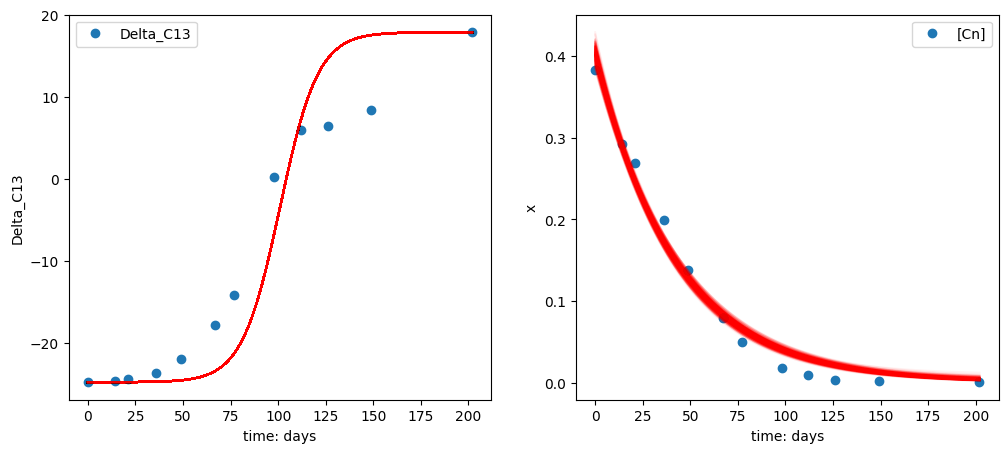

In [14]:
def plotter(sampler_delta,sampler_x,time=time,dd=dd,x=x):
    plt.ion()   
    samples = sampler_delta.flatchain
    samples_x = sampler_x.flatchain
#     tt=np.linspace(time[0],time[-1],1000)
    fig=plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)  
    plt.plot(time,dd,'o',label="Delta_C13")
    for Vd in samples[np.random.randint(len(samples), size=300)]:
        plt.plot(tt, model_delta(Vd, tt), color="r", alpha=0.051)
   #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('time: days')
    plt.ylabel(r'Delta_C13')
    plt.legend()
    plt.subplot(1,2,2)  
    plt.plot(time,x,'o',label="[Cn]")
    for Vc in samples_x[np.random.randint(len(samples_x), size=300)]:
        plt.plot(tt,model_x(Vc,tt),color="r",alpha=0.051)
   # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('time: days')
    plt.ylabel(r'x')
    plt.legend()
    plt.show()

plotter(sampler_delta,sampler_x)

------------------
------

## Step 3： Fitting curves

### Utilize the two curves to derive the reverse ratio
#### (1) Data simulation
\begin{align}
x(t)&= c_0+(c_1-c_0) e^{-\lambda t}
\\ \delta(t) & = d_0+\frac{d_1-d_0}{1+e^{-k(t-d_2)}}
\\ R_A(t) &= R_{std} \big(1+\frac{\delta(t)}{1000}\big)
\\ y(t) &= \frac{n R_A(t)}{1+R_A(t)} x(t)
\end{align}

#### (2) Derivatives of some functions

\begin{align}
x^\prime(t)&= -\lambda (c_1-c_0)e^{-\lambda t}
\\ \delta^\prime(t) & = \frac{k(d_1-d_0)e^{-k(t-d_2)}}{(1+e^{-k(t-d_2)})^2}
\\ (R_A)^\prime(t) &= \frac{R_{std}}{1000}\delta^\prime(t)
\\ y^\prime(t) &= \frac{n (R_A)^\prime(t)}{(1+R_A(t))^2} x(t)+\frac{x^\prime(t)}{x(t)} y(t)
\end{align}


#### (3) Revese ratio
$$\mu(t) = \big[\frac{y^\prime(t)}{x^\prime(t)} - {\alpha_+}\frac{y(t)}{x(t)}\big]\Big/\big[{\alpha_+}\frac{y(t)}{x(t)}-{n}{\alpha_-}\frac{b-y}{a-nx}\big]$$

In [15]:
# n=4
# R_std=0.01123720
# alp1=1
# alp2=1/0.9975

def D_delta(Vd,t):
    d0,d1,d2,k = Vd
    return k*(d1-d0)*np.exp(-k*(t-d2))/(1+np.exp(-k*(t-d2)))**2

def D_x(Vc,t):
    c0,c1,lam = Vc
    return -lam*(c1-c0)*np.exp(-lam*t)

def MUt(Vd,Vc,t):
    x = model_x(Vc,t)
    Dx = D_x(Vc,t)
    RA = R_std*(1+model_delta(Vd,t)/1000)
    y = n*RA/(1+RA)*x
    DRA = R_std*D_delta(Vd,t)/1000
    Dy = n*DRA/(1+DRA)**2*model_x(Vc,t)+Dx/x*y
    return (Dy/Dx-alp1*y/x)/(alp1*y/x-n*alp2*(b-y)/(a-n*x))

# D_x(Vc_max,time)
# # mu = MUt(Vd_max,Vc_max,time)
# mutt = MUt(Vd_max,Vc_max,tt)
# plt.plot(time,mu,'o',label='$\mu$: Points at time')
# plt.plot(tt,mutt,label='$\mu$: Curve ')
# plt.legend()
# plt.show()

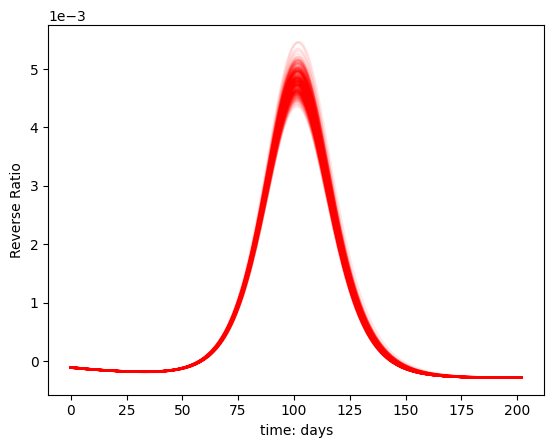

In [16]:
samples = sampler_delta.flatchain
samples_x = sampler_x.flatchain
Vd_rand = samples[np.random.randint(len(samples), size=300)]
Vc_rand = samples_x[np.random.randint(len(samples_x), size=300)]
# V=np.append(Vd_rand,Vc_rand)
V=np.concatenate((Vd_rand,Vc_rand),axis=1)
# tt=np.linspace(0,time[-1],200)
for VdVc in V:
    Vd=VdVc[0:4]
    Vc=VdVc[4:7]
    plt.plot(tt, MUt(Vd, Vc, tt), color="r", alpha=0.1)
plt.xlabel('time: days')
plt.ylabel(r'Reverse Ratio')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.legend()
plt.show()


## Test convergence of the parameters in Logistic function

(2500,)

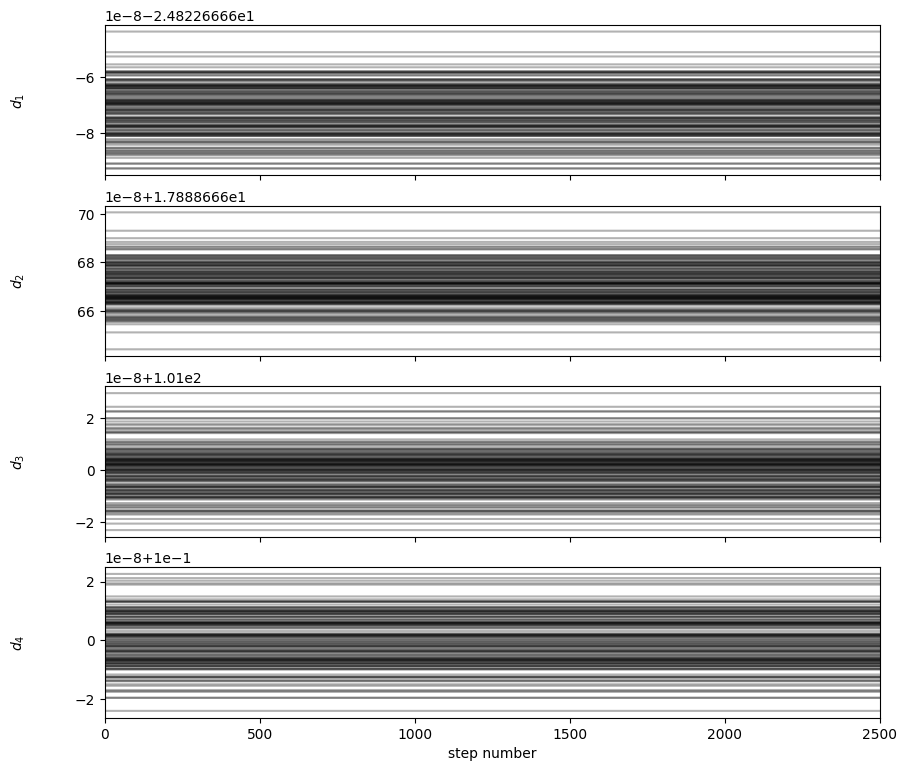

In [17]:
fig, axes = plt.subplots(4, figsize=(10,9), sharex=True)
samples_delta = sampler_delta.get_chain()
labels = ["$d_1$", "$d_2$", "$d_3$",'$d_4$']
for i in range(ndim_delta):
    ax = axes[i]
    ax.plot(samples_delta[:, 1:200, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_delta))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
samples_delta[:, 1, i].shape

## Test convergence of the parameters in exponential decay function

(2500, 128, 3)


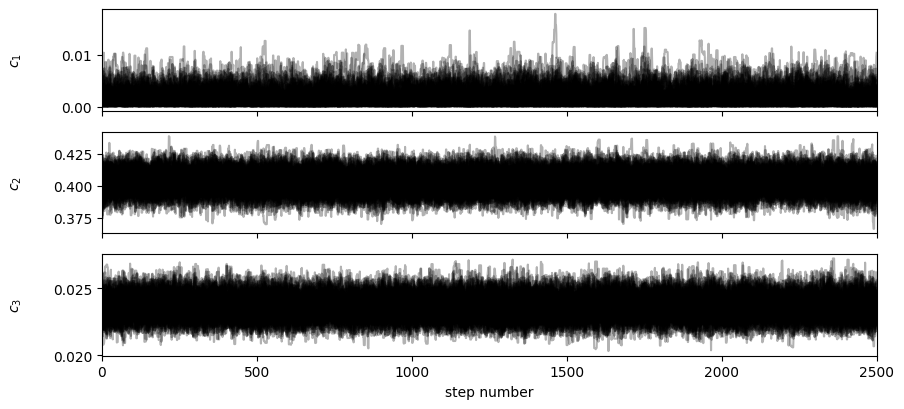

In [18]:
fig, axes = plt.subplots(ndim_x, figsize=(10, 4.5), sharex=True)
samples_x = sampler_x.get_chain()
labels = ["$c_1$", "$c_2$", "$c_3$"]
for i in range(ndim_x):
    ax = axes[i]
    ax.plot(samples_x[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_x))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
print(samples_x.shape)

--------------

## Step 4：Posterior Spread（Confidential-like interval）
### Draw a random sample from the posteriors and find the spread at each "x-value" where we evaluated our model.

In [19]:
def sample_walkers_delta(nsamples,flattened_chain,tt):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model_delta(i,tt)
        models.append(mod)
#     spread = np.max(models)-np.min(models)    
#     spread = np.std(models,axis=0)
    med_model = np.mean(models,axis=0)
    temp = np.sort(models,axis=0)
    p = int(len(med_model)*0.025)
    spread = [temp[-p]-med_model,med_model-temp[p]]
    return med_model,spread


new_samples_d = sampler_delta.flatchain
med_model,spread = sample_walkers_delta(1000,new_samples_d,tt)
print(new_samples_d.shape)

(320000, 4)


(203,)
(203,)


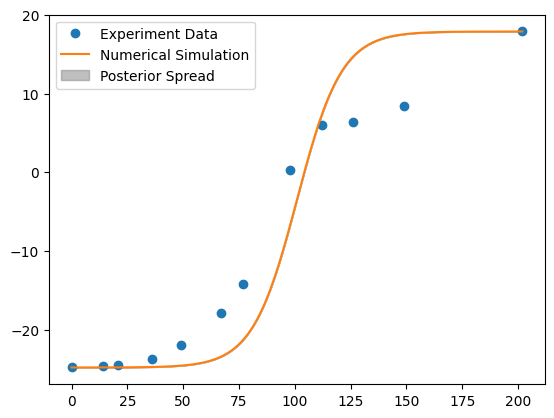

In [20]:

print(tt.shape)
print(med_model.shape)
plt.plot(time,delta_C13,'o',label='Experiment Data')
plt.plot(tt,med_model,label='Numerical Simulation')
plt.fill_between(tt,med_model-spread[1],med_model+spread[0],color='grey',alpha=0.5,label='Posterior Spread')
plt.legend()
plt.show()
# spread;
# med_model


In [21]:
def sample_walkers_x(nsamples,flattened_chain,tt):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model_x(i,tt)
        models.append(mod)
    med_model = np.median(models,axis=0)
    temp = np.sort(models,axis=0)
    p = int(len(med_model)*0.025)
    spread = [temp[-p]-med_model,med_model-temp[p]]
    return med_model,spread
new_samples_x =  sampler_x.flatchain
med_model_x,spread_x = sample_walkers_x(1000,new_samples_x,tt)
# print(med_model)

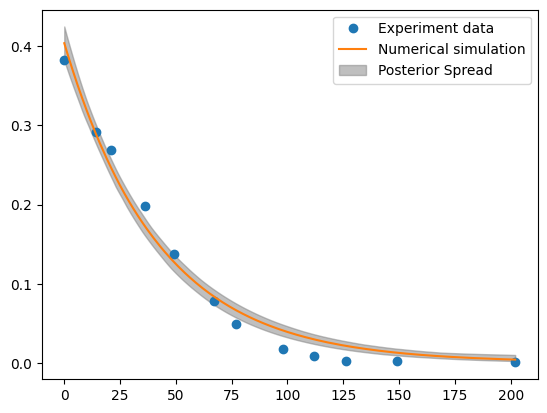

In [22]:
plt.plot(time,x,'o',label='Experiment data')
plt.plot(tt,med_model_x,label='Numerical simulation')
plt.fill_between(tt,med_model_x-spread_x[1],med_model_x+spread_x[0],color='grey',alpha=0.5,label='Posterior Spread')
plt.legend()
plt.show()

In [23]:
def sample_walkers_mu(nsamples,flattened_chain_d,flattened_chain_x,tt):
    models = []
    draw_d = np.floor(np.random.uniform(0,len(flattened_chain_d),size=nsamples)).astype(int)
    Vd = flattened_chain_d[draw_d]
    draw_x = np.floor(np.random.uniform(0,len(flattened_chain_x),size=nsamples)).astype(int)
    Vx = flattened_chain_x[draw_x]
    V=np.concatenate((Vd,Vx),axis=1)
    for i in V:
        di = i[0:4]
        xi = i[4:7]
        mod = MUt(di,xi,tt)       
        models.append(mod)
    med_model = np.median(models,axis=0)
    temp = np.sort(models,axis=0)
    p = int(len(med_model)*0.025)
    temp_d = np.sort(Vd,axis=0)
    temp_x = np.sort(Vx,axis=0)
    dme= np.median(Vd,axis=0);dne= temp_d[p];dpo=temp_d[-p];
    xme= np.median(Vx,axis=0);xne= temp_x[p];xpo=temp_x[-p];
    vd = [dne,dme,dpo]; vc=[xne,xme,xpo];
    spread = [temp[-p]-med_model,med_model-temp[p]]
    return med_model,spread,vd,vc
med_model_mu,spread_mu,vd,vc = sample_walkers_mu(1000,new_samples_d,new_samples_x,tt)

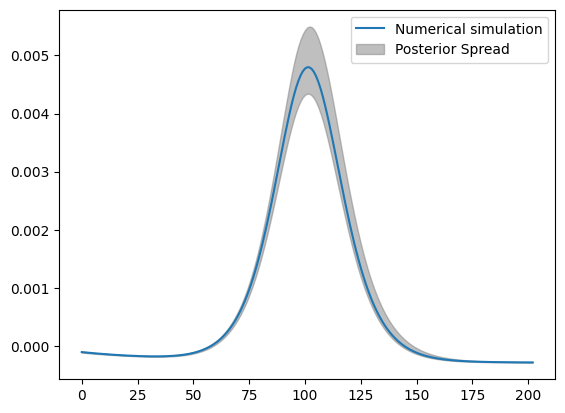

In [24]:
plt.plot(tt,med_model_mu,label='Numerical simulation')
plt.fill_between(tt,med_model_mu-spread_mu[1],med_model_mu+spread_mu[0],color='grey',alpha=0.5,label='Posterior Spread')
plt.legend()
plt.show()

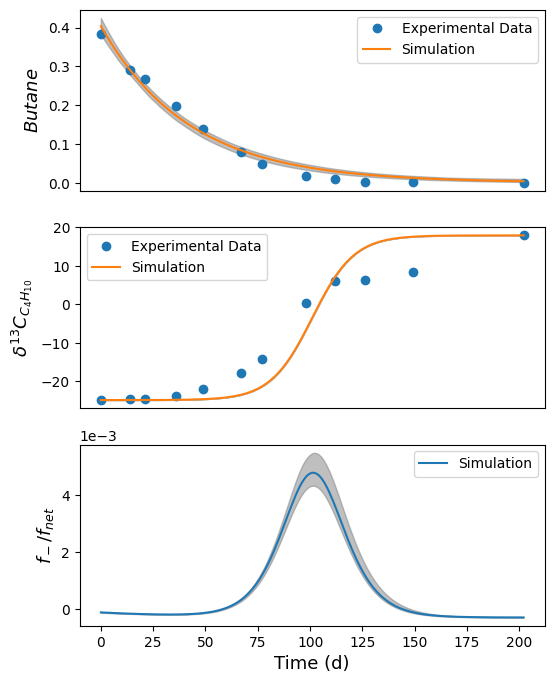

In [25]:
plt.figure(figsize=(6,8))
plt.subplot(3,1,1)
plt.plot(time,x,'o',label='Experimental Data')
plt.plot(tt,med_model_x,label='Simulation')
plt.fill_between(tt,med_model_x-spread_x[1],med_model_x+spread_x[0],color='grey',alpha=0.5)
plt.xticks([])
plt.ylabel('$Butane$',fontsize=13)
plt.legend()
plt.subplot(3,1,2)
plt.plot(time,delta_C13,'o',label='Experimental Data')
plt.plot(tt,med_model,label='Simulation')
plt.fill_between(tt,med_model-spread[1],med_model+spread[0],color='grey',alpha=0.5)
plt.xticks([])
plt.ylabel('$\delta^{13}C_{C_4H_{10}}$',fontsize=13)
plt.legend()
plt.subplot(3,1,3)
plt.plot(tt,med_model_mu,label='Simulation')
plt.fill_between(tt,med_model_mu-spread_mu[1],med_model_mu+spread_mu[0],color='grey',alpha=0.5)
plt.ylabel('$f_-/f_{net}$',fontsize=13)
plt.xlabel('Time (d)',fontsize=13)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend()
plt.show()

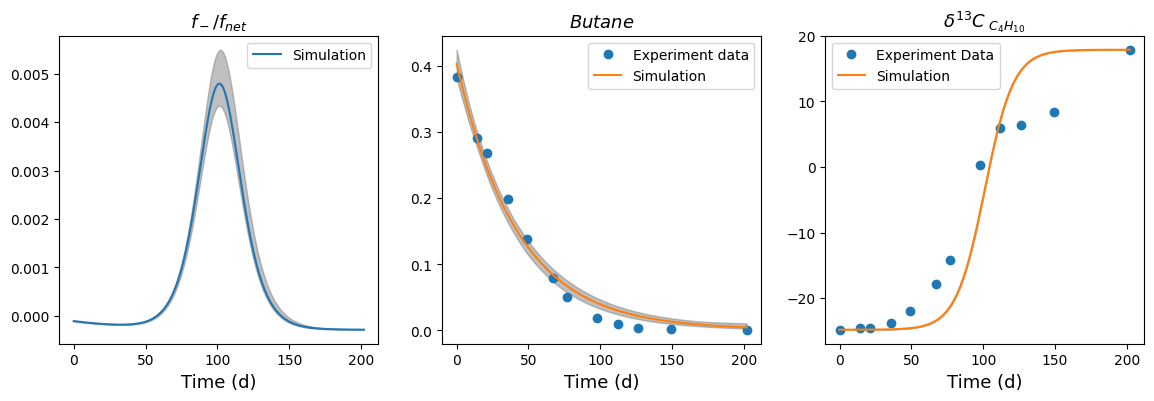

In [26]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,2)
plt.plot(time,x,'o',label='Experiment data')
plt.plot(tt,med_model_x,label='Simulation')
plt.fill_between(tt,med_model_x-spread_x[1],med_model_x+spread_x[0],color='grey',alpha=0.5)
plt.xlabel('Time (d)',fontsize=13)
plt.title('$Butane$',fontsize=13)
plt.legend()
plt.subplot(1,3,3)
plt.plot(time,delta_C13,'o',label='Experiment Data')
plt.plot(tt,med_model,label='Simulation')
plt.fill_between(tt,med_model-spread[1],med_model+spread[0],color='grey',alpha=0.5)
plt.xlabel('Time (d)',fontsize=13)
plt.title('$\delta^{13}C_{~C_4H_{10}}$',fontsize=13)
plt.legend()
plt.subplot(1,3,1)
plt.plot(tt,med_model_mu,label='Simulation')
plt.fill_between(tt,med_model_mu-spread_mu[1],med_model_mu+spread_mu[0],color='grey',alpha=0.5)
plt.title('$f_-/f_{net}$',fontsize=13)
plt.xlabel('Time (d)',fontsize=13)
plt.legend()
plt.show()

## Step 5 Data Storage

In [28]:
data_mu= np.transpose([tt,med_model_mu,med_model_mu-spread_mu[1],med_model_mu+spread_mu[0]])
data_x_d = np.transpose([med_model_x,med_model_x-spread_x[1],med_model_x+spread_x[0],med_model,med_model-spread[1],med_model+spread[0]])
data1=np.concatenate([vc,vd],axis=1)
data2=np.concatenate([data_mu,data_x_d],axis=1)
with open("./Results/Set%d_sigma_"%Set+'%.3f.csv'%sig,"w",encoding="UTF-8",newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Set%d:'%Set])
    writer.writerow(['Sigma=%f'%sig,'','initial=%f'%x0,'','alp-$=%f'%alp_negative,'','alp+$=%f'%alp_positive])
    writer.writerow([])
    writer.writerow([])
    writer.writerow(['Numerical Result I:','','burn-in=2000','','walkers=128','','iteration=5000'])
    writer.writerow(['prior distribution'])
    writer.writerow([])
    writer.writerow(['c0','c1','lambda','d0','d1','d2','k'])
    writer.writerows(data1)
#     writer.writerow(['c1','c2','c3'])
#     writer.writerows(vc)
#     writer.writerow(['d1','d2','d3','d4'])
#     writer.writerows(vd)
    writer.writerow([])
    writer.writerow([])
    writer.writerow(['Numerical Result II:','','samples=1000','','Confidence level=5%'])
    writer.writerow([])
    writer.writerow(['time','mu','mu-','mu+',"xButane",'xButane-','xButane+','delta13C','delta13C-','delta13C+'])
    writer.writerows(data2)